# Interest Rate Curves 

A $n\times 1$ market swap is an OTC derivative in which $n$ exchanges of flows at predetermined dates take place. The market convention is such that:

$$
    V_{fixed} = V_{floating}
$$

In which $V_{fixed}$,  $V_{floating}$ are defined as:
$$
    V_{fixed} = \sum_{k=1}^{n}r_n\tau_n P(0, t_k)
$$
and,
$$
    V_{float} = \sum_{k=1}^nF(t_{k-1}, t_k)\tau_n P(0, t_k); t_0 = 0
$$

Where
* $r_n$ is the fixed rate to pay $n$ times;
* $P(0, t_k)$ is the discount factor from valuation date ($t_0$) to the $k$-th flow;
* $\tau_k$ the fraction of time (or length of the $k$-th flow); and
* $F(t_{k-1}, t_k)$ is the forward rate from periods $t_{k-1}$ to $t_k$.

For simple compounding interest, $F(t_{k-1}, t_k)$ is defined as
$$
    F(t_{k-1}, t_k) = \left(\frac{P(0, t_{k-1})}{P(0, t_k)} - 1\right) \frac{1}{\tau_k}
$$

In [1]:
%matplotlib inline
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
from pyrate import RateCurves


# Load the holidays
holidays = []
with open("files/holidays.txt", "r") as f:
    dates = f.read().split("\n")
    for date in dates:
        holidays.append(datetime.strptime(date, "%m/%d/%y"))

# Initialize the curve 
# The constant coupon rates for nx1 swaps trading liquid in the market
mid_mkt = np.array([0.0409 ,  0.04315,  0.0446 ,  0.046  ,  0.04765,  0.05035,
                    0.05245,  0.0543 ,   0.05605,  0.05905,  0.06215,  0.06401,
                    0.0668 ,  0.06911,  0.07142])

# 'n' flows of of a variable rate v.s. one fixed rate
nx1_instruments = np.array([1, 3, 6, 9, 13, 26, 39, 52, 65, 91, 130, 156, 195, 260, 390])

val_date = datetime(2016, 6, 27)
tiie28 = RateCurves(val_date, mid_mkt, nx1_instruments, 28, holidays)

In [2]:
print(tiie28.discount_rates)
print(tiie28.fitted_curve)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
False


In [3]:
tiie28.fit_curve()
print(tiie28.discount_rates)
print(tiie28.fitted_curve)

[ 0.04089999  0.04330003  0.04500234  0.04668823  0.0487722   0.05300998
  0.05695582  0.06097714  0.06527678  0.07444921  0.08906129  0.10105983
  0.12491065  0.16995148  0.31693922]
True


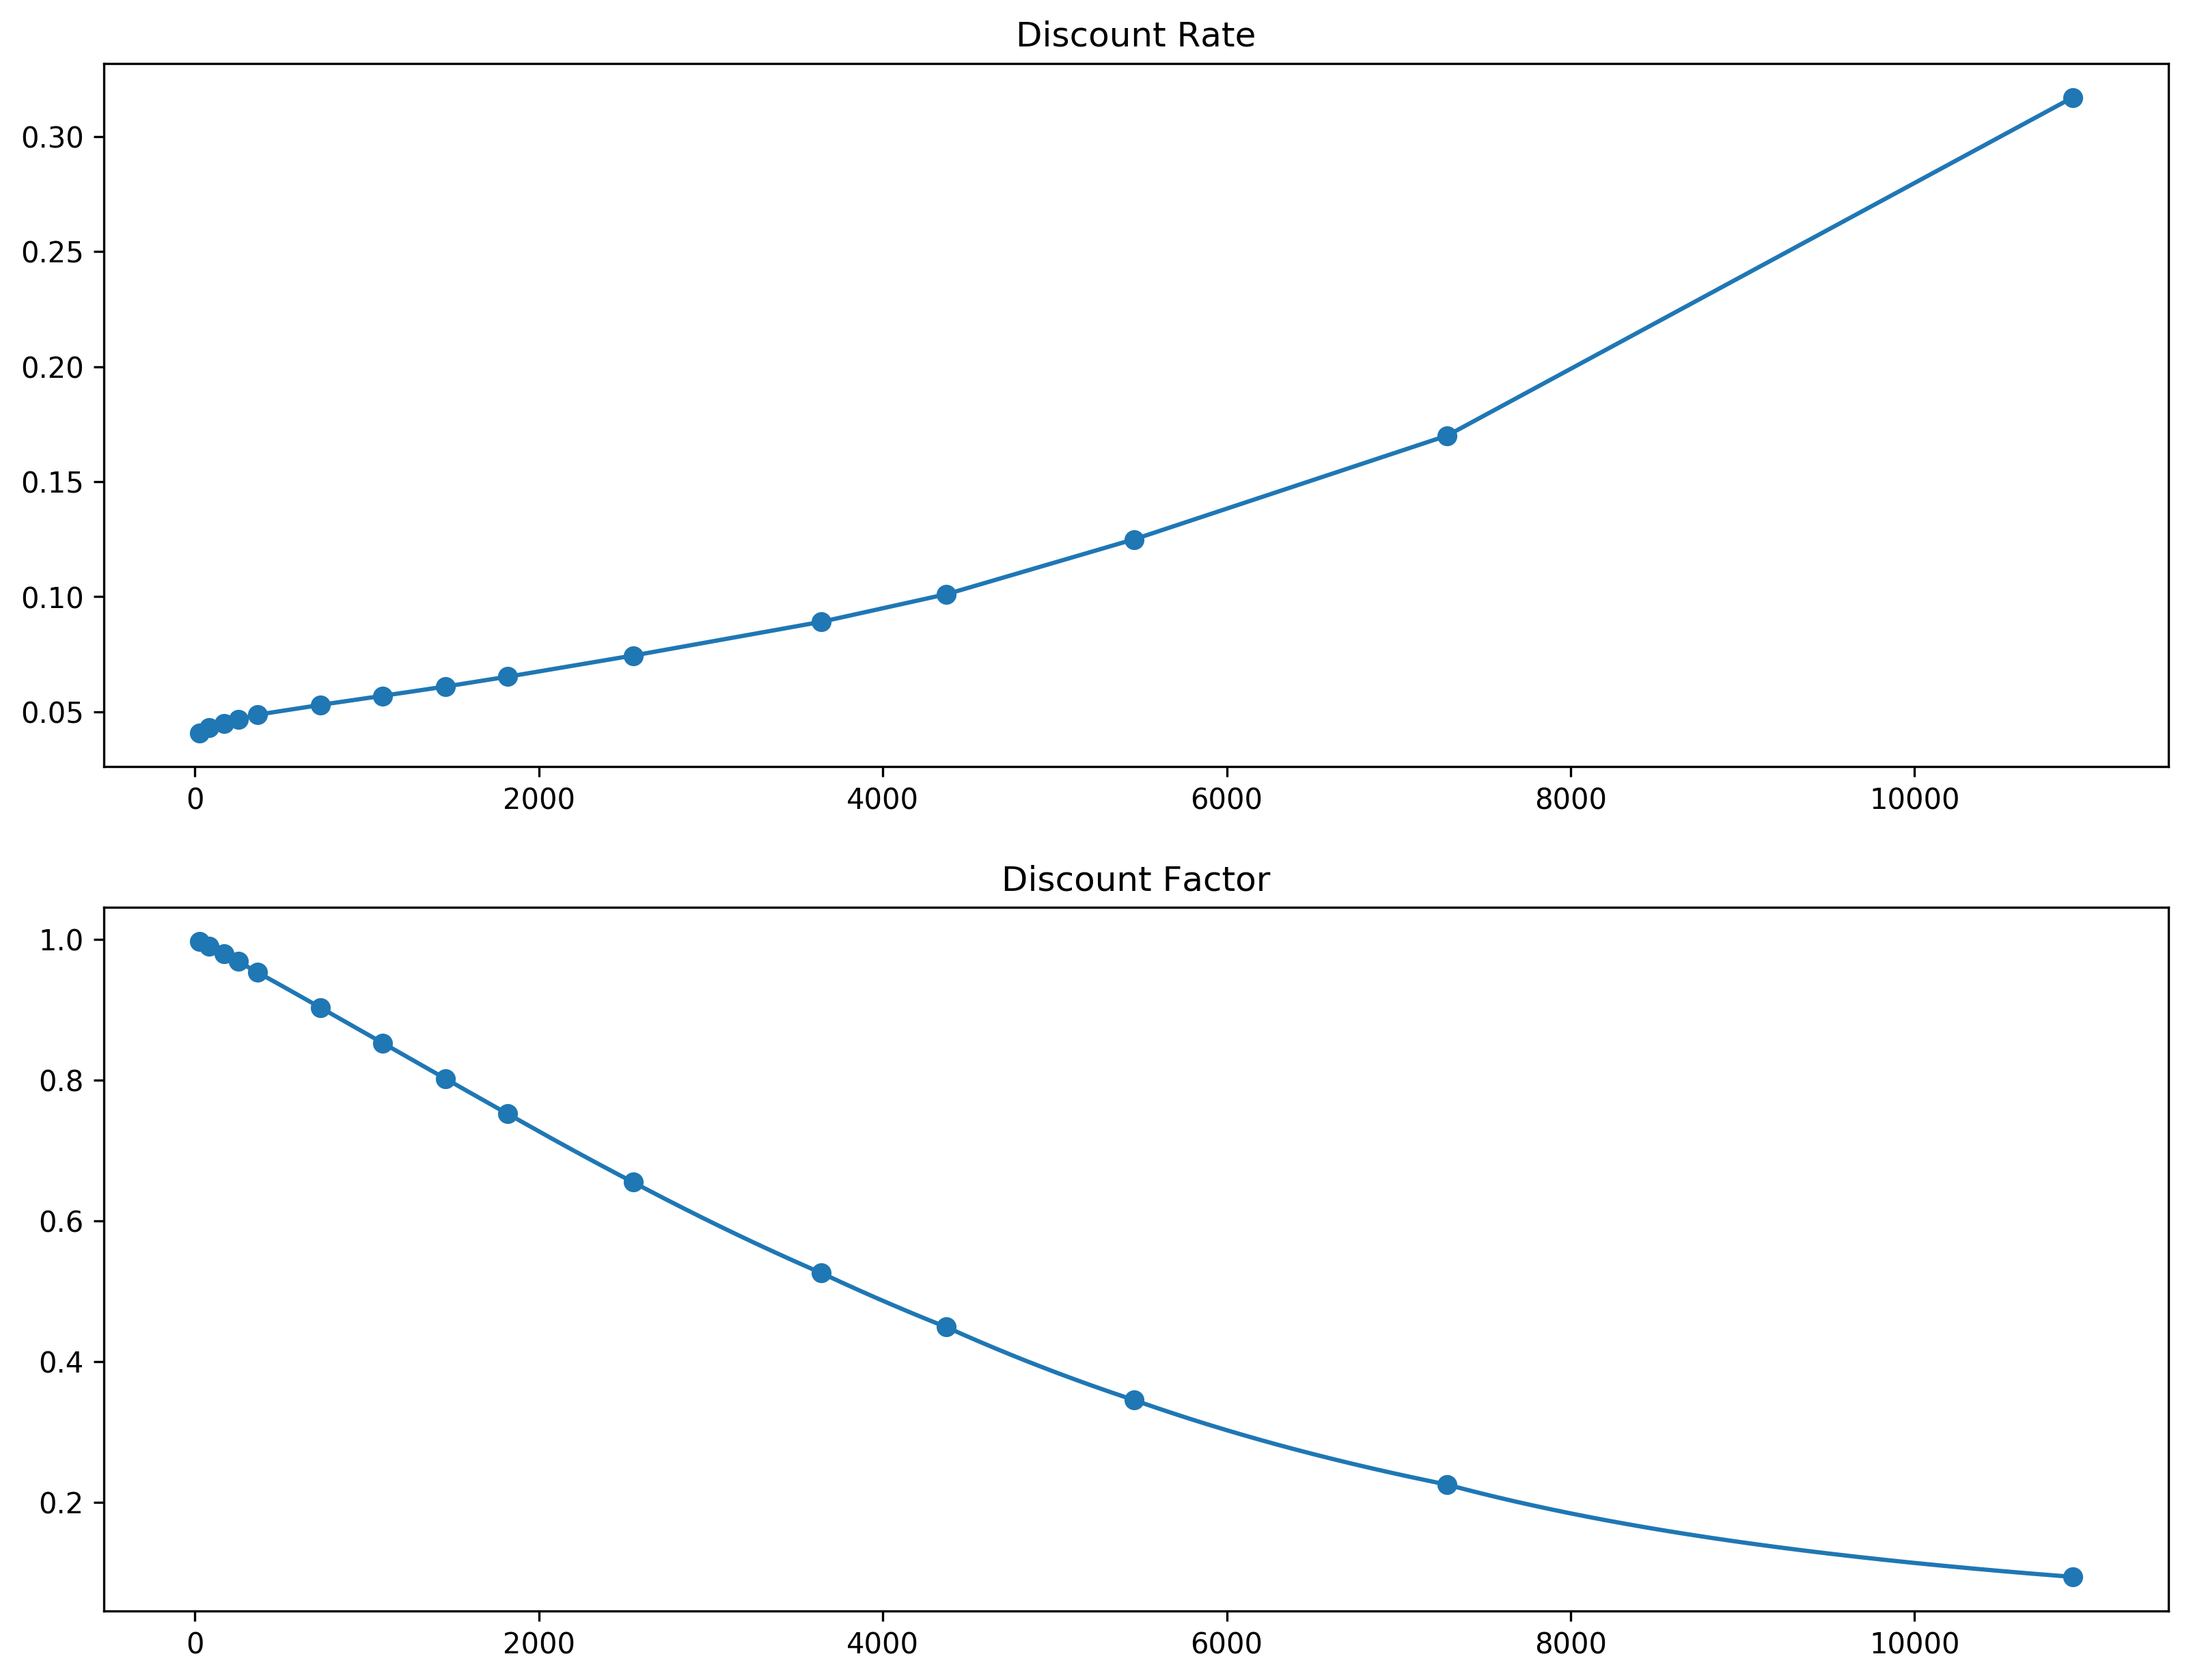

In [50]:
x = np.arange(28, 10921)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 10), dpi=300)
ax1.plot(x, tiie28.rate_curve(x)) 
ax1.scatter(tiie28.days_to_pillar, tiie28.rate_curve(tiie28.days_to_pillar))
ax1.set_title("Discount Rate")

ax2.plot(x, 1 /( 1 + tiie28.rate_curve(x) * x / 360))
ax2.scatter(tiie28.days_to_pillar, 1 /( 1 + tiie28.rate_curve(tiie28.days_to_pillar) * tiie28.days_to_pillar / 360))
ax2.set_title("Discount Factor");

In [140]:
# Pricing the fixed rate swap
r, n = tiie28.market_coupons[-1], tiie28.number_flows[-1]
coupon_days = tiie28.length_flows(n).cumsum()

tau_k = tiie28.length_flows(n) / 360
rate_k = tiie28.rate_curve(coupon_days)
discount_factor = 1 / (1 + rate_k * coupon_days / 360)

# Fixed Leg: PV
fixed_pv = np.sum(r * tau_k * discount_factor)

# Variable leg: PV
variable_pv = 1 - discount_factor[-1]

In [145]:
fixed_pv

0.90578324347992489

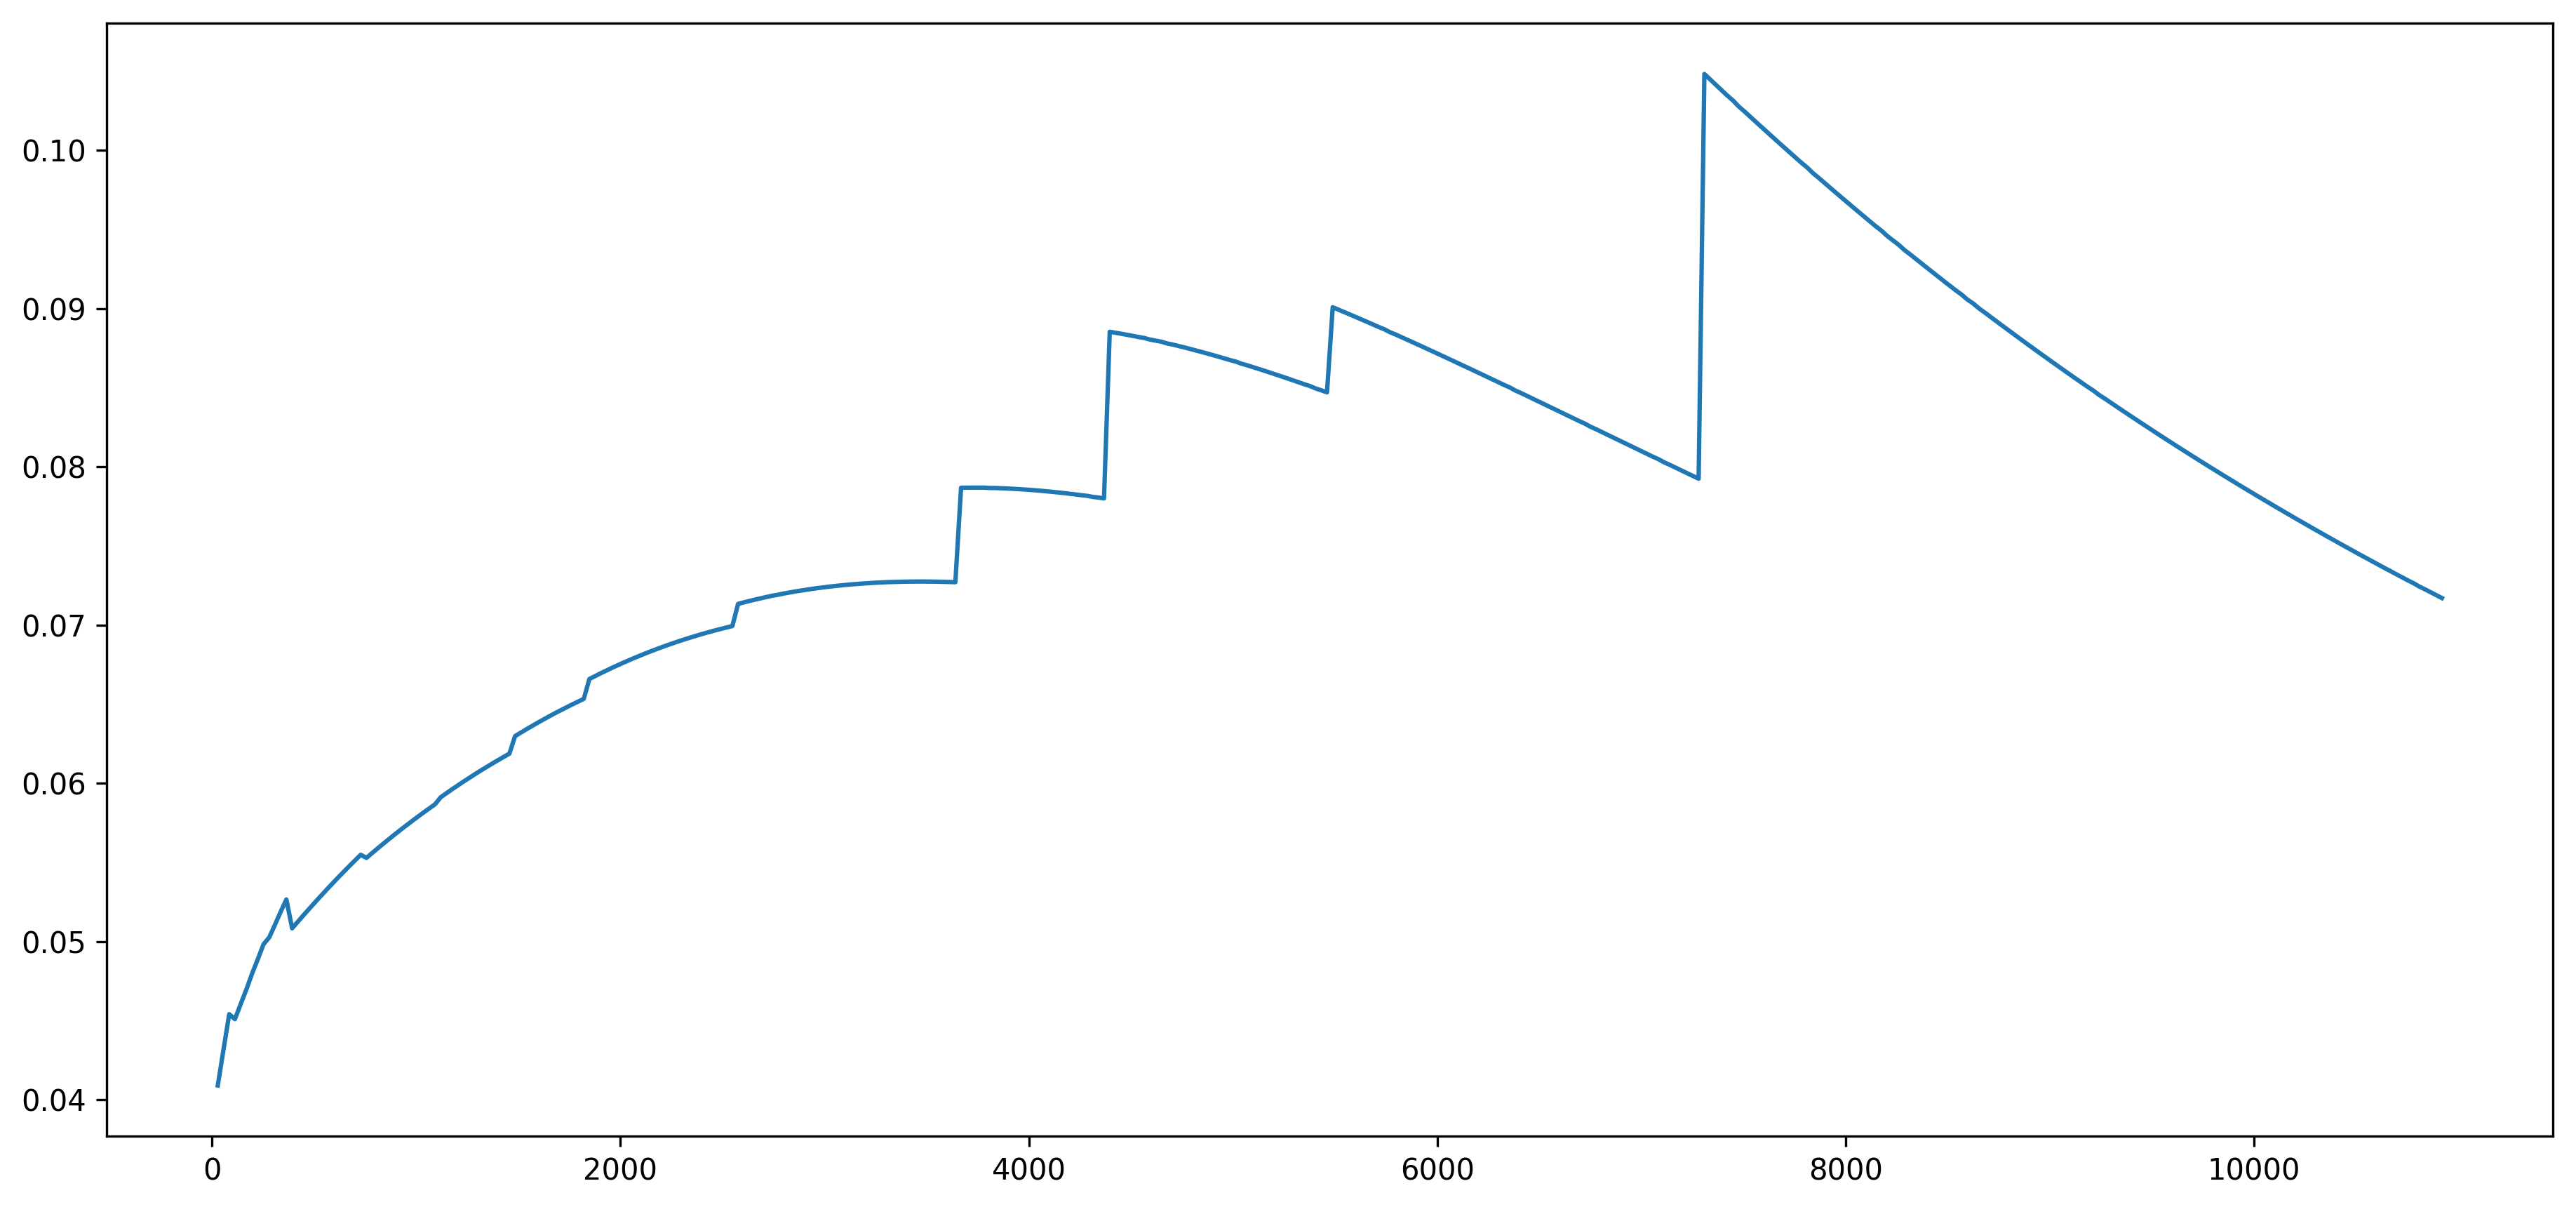

In [153]:
coupon_duration = tiie28.length_flows(390)
tau = coupon_duration / 360
time = coupon_duration.cumsum()

long_period = 1 / (1 + tiie28.rate_curve(time) * time / 360)
short_period = np.append(1, long_period[:-1])

fwd = (short_period / long_period - 1) / tau

plt.figure(figsize=(15,7), dpi=300)
plt.plot(time, fwd);

In [154]:
np.sum(fwd * tau_k * discount_factor)

0.90578324033067936

In [150]:
fixed_pv

0.90578324347992489